# Regression models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

from pylab import cm
from matplotlib import colors as mcol

from netCDF4 import Dataset as NetCDFFile

## Least squares example

In [15]:
def least_squares_regression_examples(x,y):
    # Create the design matrix by adding a column of ones to the independent variable
    X = np.column_stack((np.ones_like(x), x))

    # Calculate the coefficients using the least squares formula
    coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    # Extract the intercept and slope coefficients
    intercept = coefficients[0]
    slope = coefficients[1]

    # Calculate the predicted values
    y_pred = intercept + slope * x

    # Calculate the total sum of squares
    ss_total = np.sum((y - np.mean(y)) ** 2)

    # Calculate the residual sum of squares
    ss_residual = np.sum((y - y_pred) ** 2)

    # Calculate the R-squared value
    r_squared = 1 - (ss_residual / ss_total)

    # Print the equation of the regression line and the R-squared value
    print(f"Regression Line: y = {intercept:.2f} + {slope:.2f}x")
    print(f"R-squared: {r_squared:.2f}")

    # Create a scatter plot of the data points
    plt.scatter(x, y, color='b', label='Data')

    # Add the regression line to the plot
    plt.plot(x, y_pred, color='r', label='Regression Line')

    # Set labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Least Squares Regression')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

Regression Line: y = 1.59 + 0.86x
R-squared: 0.95


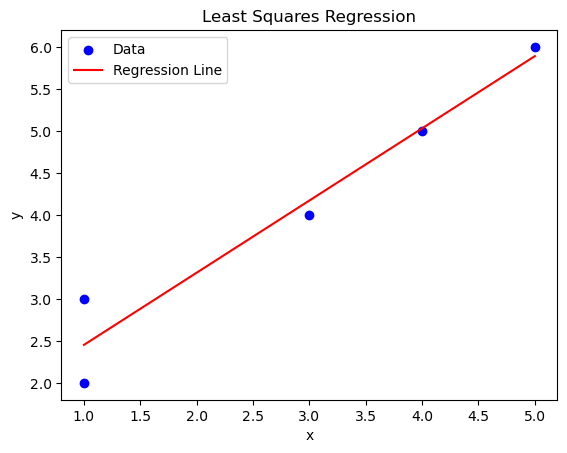

In [12]:
# Define the independent variable (x) and dependent variable (y) data
x = np.array([1, 1, 3, 4, 5])
y = np.array([2, 3, 4, 5, 6])
least_squares_regression_examples(x,y)

Regression Line: y = 0.50 + 0.91x
R-squared: 0.59


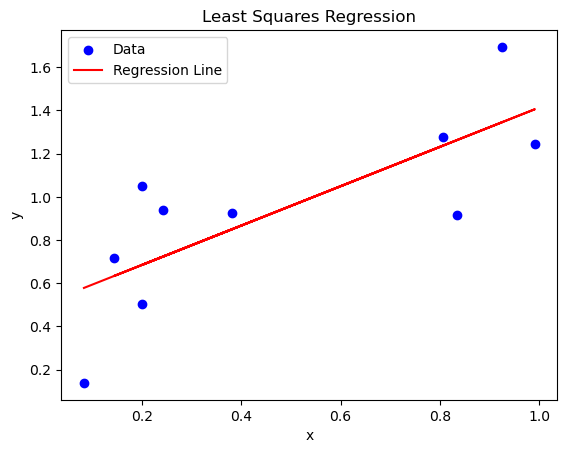

In [17]:
x = np.array([np.random.random() for i in range(10)])
y = np.array([np.random.random()+x[i] for i in range(10)])
least_squares_regression_examples(x,y)

## USGS regression equations

[https://pubs.usgs.gov/sir/2007/5204/](https://pubs.usgs.gov/sir/2007/5204/)  
USGS Scientific Investigations Report 2007-5204  
Magnitude and Frequency of Floods in Alabama, 2003  
By T.S. Hedgecock and Toby D. Feaster  
![alabama regression equations](alabama.png "Alabama regression equations")  

[https://pubs.er.usgs.gov/publication/sir20125113](https://pubs.er.usgs.gov/publication/sir20125113)  
USGS Scientific Investigations Report 2012-5113  
Methods for determining magnitude and frequency of floods in California, based on data through water year 2006  
https://pubs.er.usgs.gov/publication/sir20125113  
![california regression equations](california.png "California regression equations")  

## Now let's use some real data to build a general model that "works" across CONUS

In [21]:
with open("camels_attributes.csv", "r") as f:
    df_attributes = pd.read_csv(f, index_col="gauge_id")
with open("camels_hydrologic_signatures.csv", "r") as f:
    df_hydrologic_signatures = pd.read_csv(f, index_col="gauge_id")
with open("camels_recurrence_intervals.csv", "r") as f:
    df_recurrence_intervals = pd.read_csv(f, index_col="gauge_id")

In [22]:
def regress_recurrence(df_attributes, df_recurrence_intervals, target_ri_period):
    X=np.array(df_attributes)
    y=np.array(df_recurrence_intervals[f"ri_{target_ri_period}"])
    A=np.array(df_attributes['area_geospa_fabric'])
    # SET UP K-FOLD
    # Split into training groups
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    # GPR (Kriging) in a K-fold loop
    rmse_list = []
    r_sq_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        A_train, A_test = A[train_index], A[test_index]

        rf = RandomForestRegressor(n_estimators=100, random_state=42,
                                      criterion="absolute_error", min_samples_leaf=1,
                                      min_samples_split=2, max_depth=None,
                                      min_weight_fraction_leaf=0)

        rf.fit(X_train, y_train)

        y_hat = rf.predict(X_test) 

        rmse_list.append(np.sqrt(np.mean((y_test - y_hat)**2)))

        correlation_matrix = np.corrcoef(y_test, y_hat)
        correlation_xy = correlation_matrix[0,1]
        r_sq_list.append(correlation_xy**2)

        plt.scatter(y_test/A_test, y_hat/A_test, c="b")
        print('rmse: {:.2f}, r-squared: {:.2f}'.format(rmse_list[-1],r_sq_list[-1]))

    plt.plot([10,2000],[10,2000], 'k')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f"{target_ri_period}-year recurrence interval (area normalized)")
    plt.xlim([10,2000])
    plt.xscale('log')
    plt.ylim([10,2000])
    plt.yscale('log')
    plt.show()
    print('Mean values:')
    print(f'rmse: {np.mean(rmse_list):.2f}, r-squared: {np.mean(r_sq_list):.2f}')

rmse: 22726.40, r-squared: 0.62
rmse: 28250.82, r-squared: 0.38
rmse: 99604.24, r-squared: 0.05
rmse: 160511.43, r-squared: 0.07
rmse: 25065.35, r-squared: 0.49


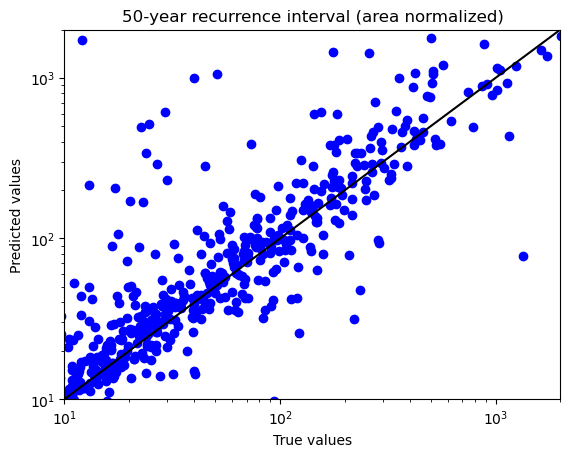

Mean values:
rmse: 67231.65, r-squared: 0.32


In [23]:
regress_recurrence(df_attributes, df_recurrence_intervals, 50)